In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
import seaborn as sns
%matplotlib inline
from subprocess import check_output

In [2]:
sub_path = "./sub_path"
all_files = os.listdir(sub_path)
all_files

['submission_03.csv',
 'submission_02.csv',
 'submission_01.csv',
 'submission_04.csv']

In [7]:
import warnings
warnings.filterwarnings("ignore")
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "mol" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()
ncol = concat_sub.shape[1]

In [8]:
concat_sub.iloc[:,1:].corr()

,mol0,mol1,mol2,mol3
mol0,1.000000,0.282473,0.115824,0.214049
mol1,0.282473,1.000000,0.332689,0.950158
mol2,0.115824,0.332689,1.000000,0.312220
mol3,0.214049,0.950158,0.312220,1.000000


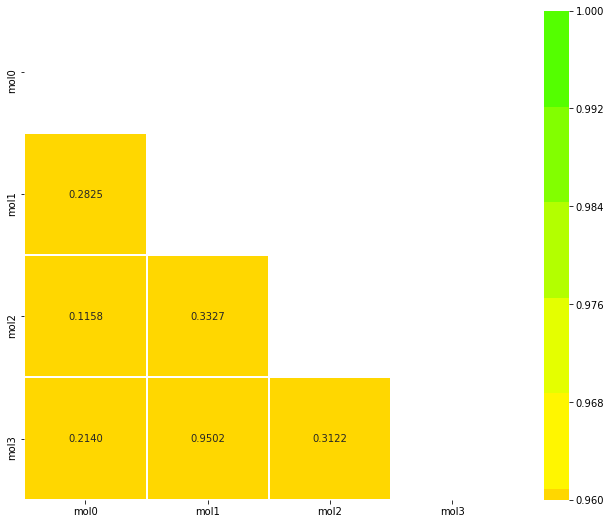

In [9]:
corr = concat_sub.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='prism', vmin=0.96, center=0, square=True, linewidths=1, annot=True, fmt='.4f')

In [10]:
concat_sub['m_max'] = concat_sub.iloc[:, 1:].max(axis=1)
concat_sub['m_min'] = concat_sub.iloc[:, 1:].min(axis=1)
concat_sub['m_median'] = concat_sub.iloc[:, 1:].median(axis=1)

In [11]:
concat_sub.describe()

,row_id,mol0,mol1,mol2,mol3,m_max,m_min,m_median
count,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,1.866454e+02,5.554121e+02,2.619740e+02,6.737280e+02,7.351698e+02,1.438172e+02,3.993863e+02
std,1.203706e+07,8.601680e+02,1.312309e+04,9.895196e+03,2.121556e+04,2.306644e+04,6.681301e+02,7.996652e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.042440e+07,1.525497e+01,2.171503e+01,1.428801e+01,2.150517e+01,2.887192e+01,1.006115e+01,2.041877e+01
50%,2.084880e+07,5.203028e+01,7.496372e+01,5.412424e+01,7.563206e+01,9.034129e+01,3.937232e+01,6.738380e+01
75%,3.127320e+07,1.335783e+02,2.266051e+02,1.526150e+02,2.324566e+02,2.611899e+02,1.079328e+02,1.920782e+02
max,4.169760e+07,5.412435e+04,1.473253e+06,1.518182e+07,3.334068e+06,1.518182e+07,5.402504e+04,1.925436e+06


In [12]:
cutoff_lo = 0.8
cutoff_hi = 0.2

In [13]:
rank = np.tril(concat_sub.iloc[:,1:ncol].corr().values,-1)
m_gmean = 0
n = 8
while rank.max()>0:
    mx = np.unravel_index(rank.argmax(), rank.shape)
    m_gmean += n*(np.log(concat_sub.iloc[:, mx[0]+1]) + np.log(concat_sub.iloc[:, mx[1]+1]))/2
    rank[mx] = 0
    n += 1

In [14]:
concat_sub['m_mean'] = np.exp(m_gmean/(n-1)**2)

In [15]:
concat_sub['meter_reading'] = concat_sub['m_mean']
concat_sub[['row_id', 'meter_reading']].to_csv('stack_mean.csv', 
                                        index=False, float_format='%.6f')

In [16]:
concat_sub['meter_reading'] = concat_sub['m_median']
concat_sub[['row_id', 'meter_reading']].to_csv('stack_median.csv', 
                                        index=False, float_format='%.6f')

In [17]:
concat_sub['meter_reading'] = np.where(np.all(concat_sub.iloc[:,1:7] > cutoff_lo, axis=1), 1, 
                                    np.where(np.all(concat_sub.iloc[:,1:7] < cutoff_hi, axis=1),
                                             0, concat_sub['m_median']))
concat_sub[['row_id', 'meter_reading']].to_csv('stack_pushout_median.csv', 
                                        index=False, float_format='%.6f')

In [18]:
concat_sub['meter_reading'] = np.where(np.all(concat_sub.iloc[:,1:7] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:7] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_mean']))
concat_sub[['row_id', 'meter_reading']].to_csv('stack_minmax_mean.csv', 
                                        index=False, float_format='%.6f')

In [19]:
concat_sub['meter_reading'] = np.where(np.all(concat_sub.iloc[:,1:7] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:7] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_median']))
concat_sub[['row_id', 'meter_reading']].to_csv('stack_minmax_median.csv', 
                                        index=False, float_format='%.6f')